# Model for predicting muscle activity based on PPN data
## Prepare and organize
### Import libraries

In [826]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa == No Quality Assurance

import sklearn
from sklearn.cluster import KMeans
import random
# ML
from sklearn.linear_model import LinearRegression 
reg=LinearRegression()
from sklearn.cross_validation import train_test_split 

pd.options.display.max_rows = 10

### Load the data

In [798]:
os.chdir('C:\\mena\\data_mat')
file_names = os.listdir()
file_names_3ch = []
file_names_4ch = []
for i in file_names:
    k = sio.whosmat(i)
    if k[0][1][1] == 3:
        file_names_3ch.append(i)
    elif k[0][1][1] == 4:
        file_names_4ch.append(i)
file_names_3ch = np.array(file_names_3ch)
# list of recordings with 
# len_freq = [ 13, 25, 28, 30, 31, \
#              35, 41, 43, 44]
# file_names_3ch = file_names_3ch[len_freq]

In [ ]:
# > 5 min: [12, 13, 16, 17, 23, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 43, 44]
# > 1 Hz: [ 13, 25, 28, 30, 31, 35, 41, 43, 44]

In [754]:
for tn in range(len(trials)):
    fr = 4000*len(spike_times[tn])/(len(emgs[tn]))
    print(fr)

3.694864921814894
2.8406622689641106
1.0198184670288353
3.220910514501978
1.9244676803526861
1.1414799952698946
5.669141465866897
4.9369644247230395
1.9625836304923088


### Create data structures

In [799]:
trials = [];
for i in file_names_3ch:
    trials.append(sio.loadmat(i))
spike_times = []; emgs = []; musc = [];

# extract 3 channels
for i in trials:
    spike_times.append(i['data'][0][1][1][0][0][0])
    emgs.append(i['data'][0][0][1][0][0][1])
    musc.append(i['data'][0][2][1][0][0][1])
    
# Convert EMG and muscle data to zscores
for ind in range(len(emgs)):
    emgs[ind] = sp.stats.zscore(emgs[ind])
    musc[ind] = sp.stats.zscore(musc[ind])

In [760]:
# check lengths of trials in seconds
trial_lens = []
for tn in range(len(emgs)):
    trial_lens.append(len(musc[tn]))
trial_lens = np.multiply(trial_lens,1/(60*4000))
np.transpose(trial_lens)

array([ 5.101675  , 35.00944167, 53.62065417,  8.98814167,  9.6043875 ,
        8.52694167, 11.78602917, 13.30102083, 24.35565   ])

### Plot the data

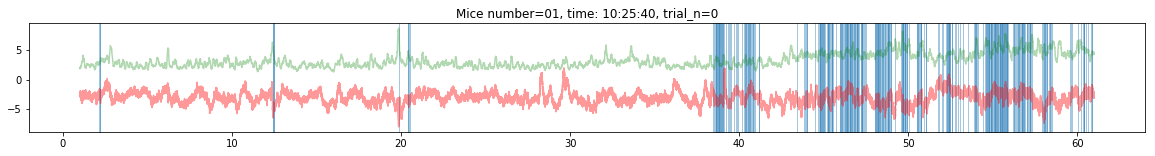

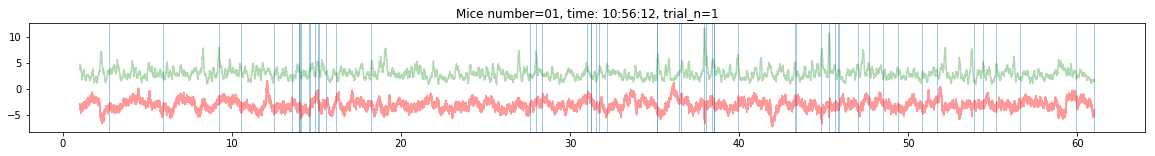

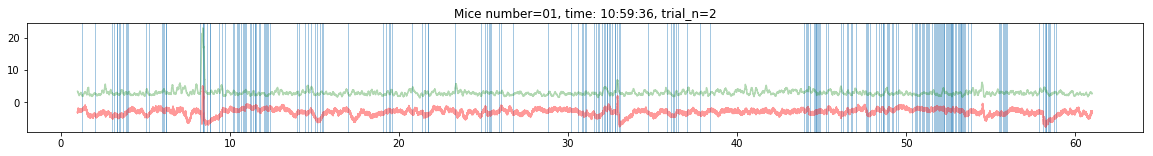

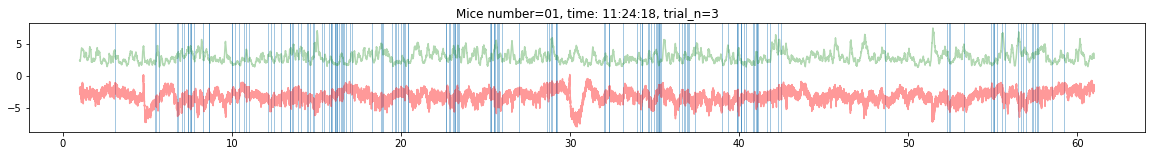

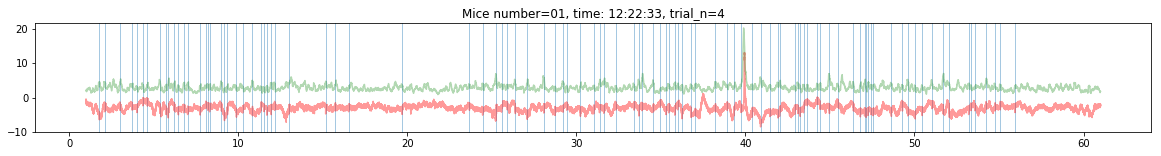

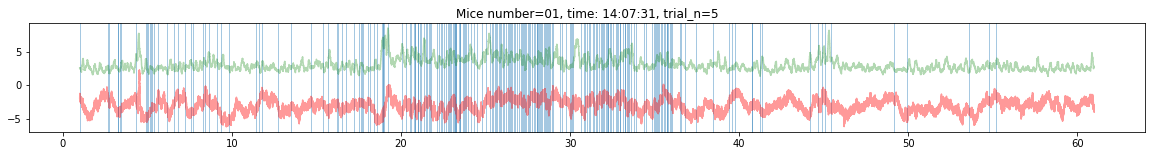

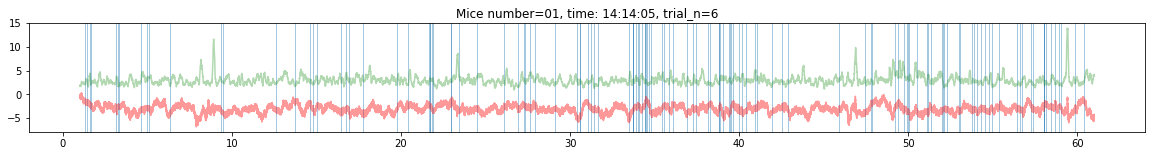

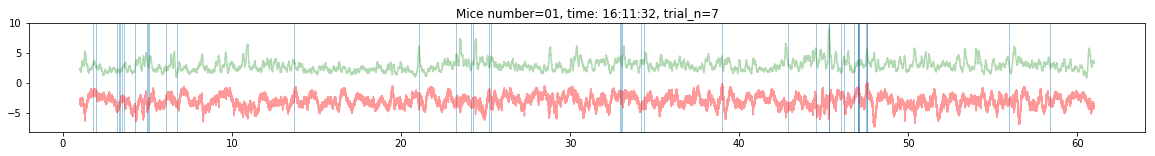

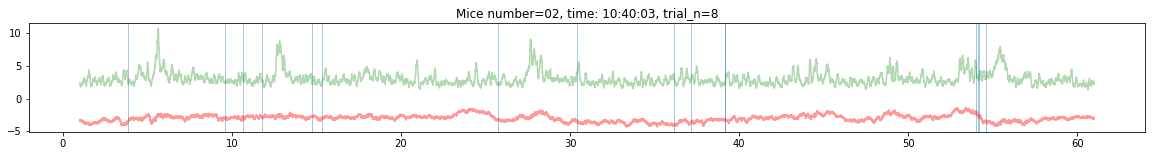

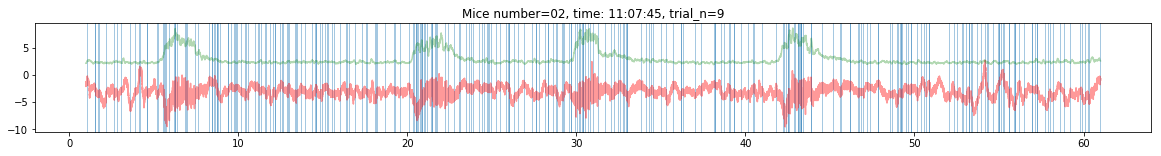

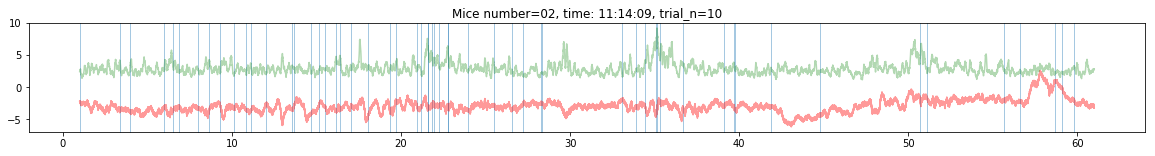

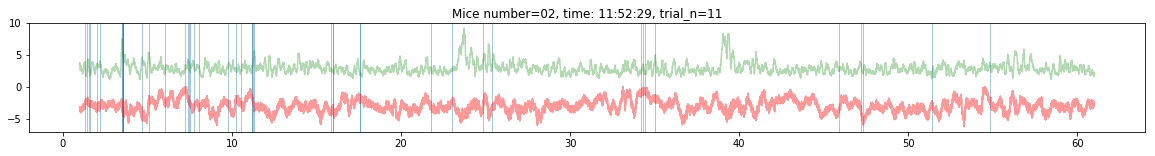

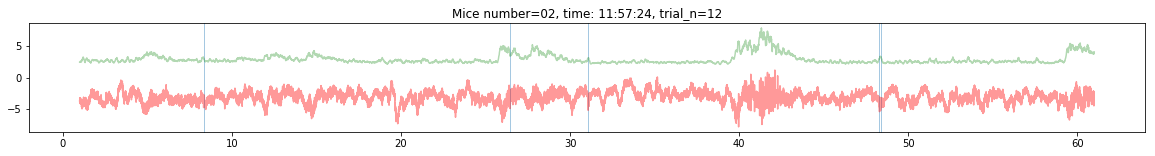

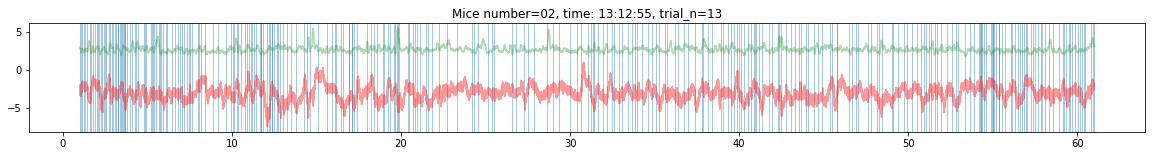

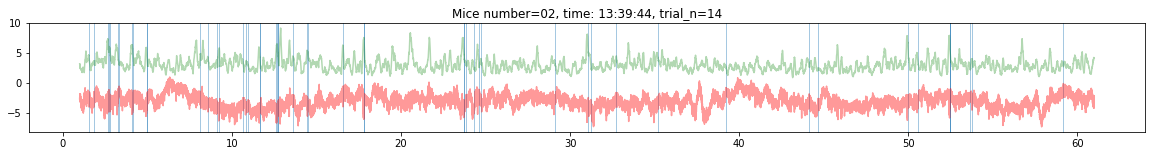

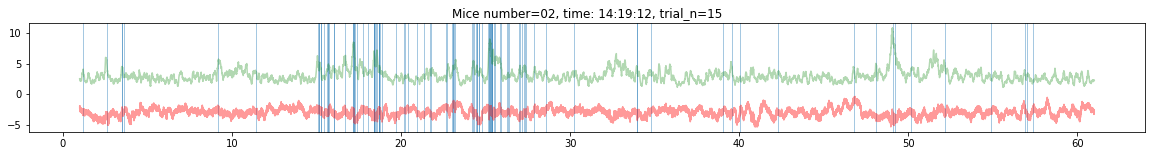

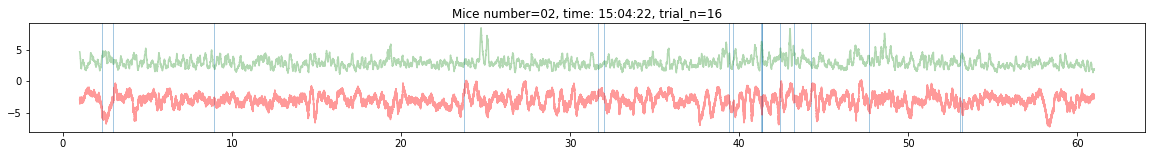

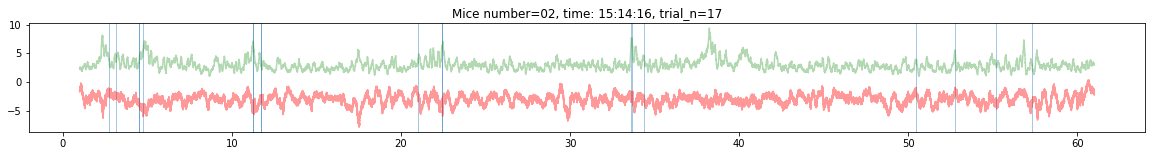

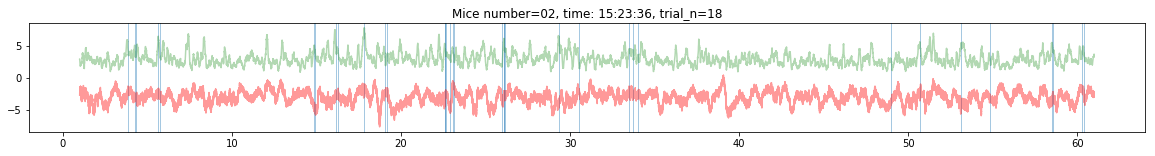

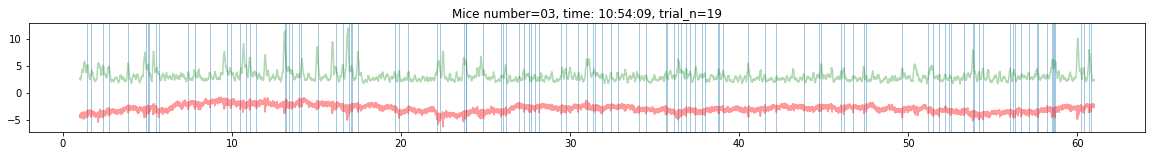

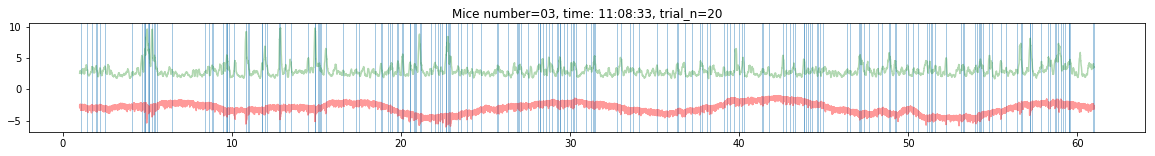

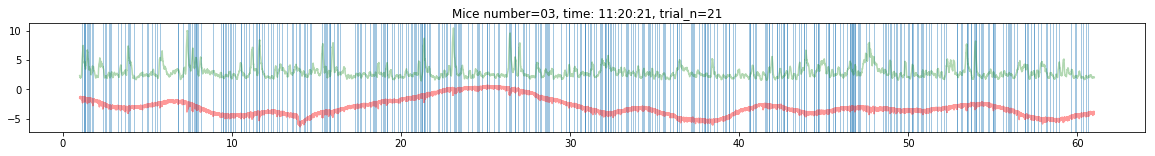

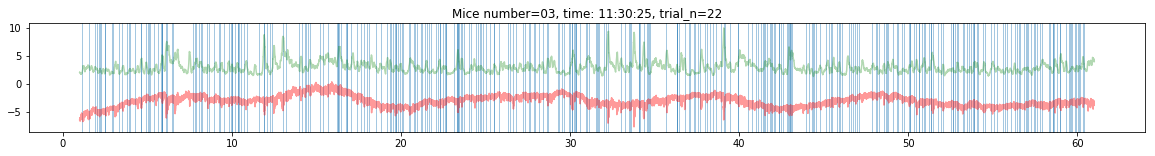

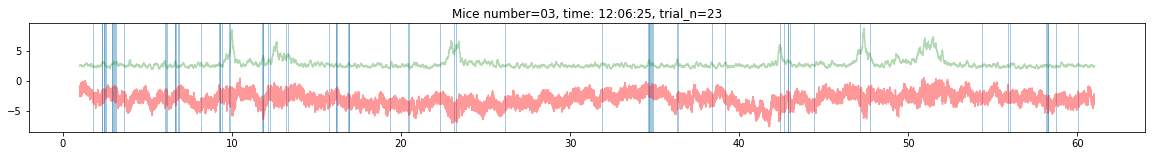

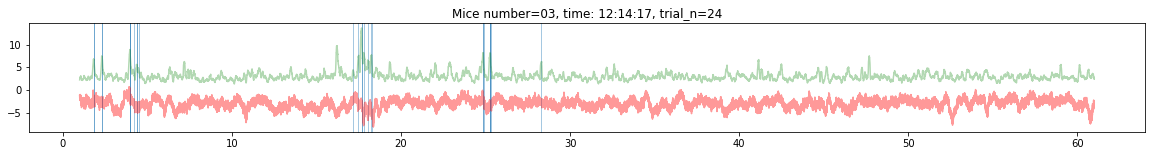

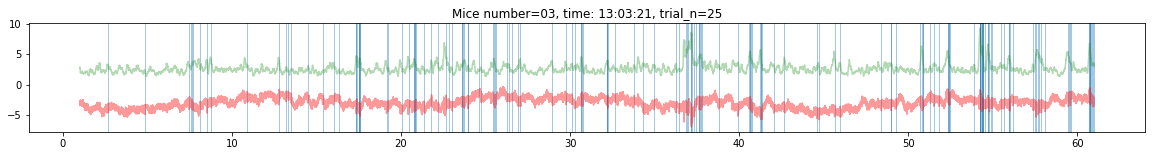

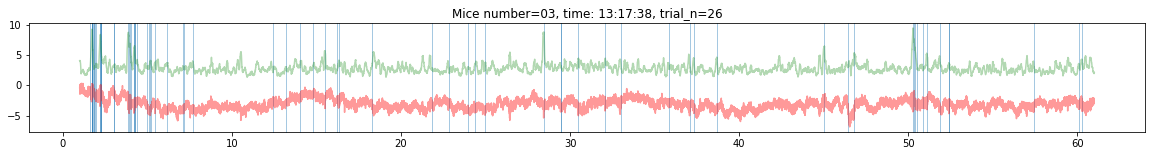

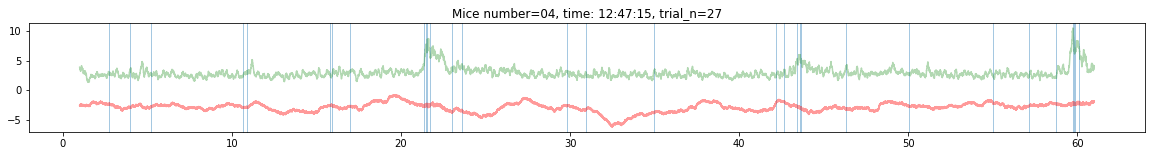

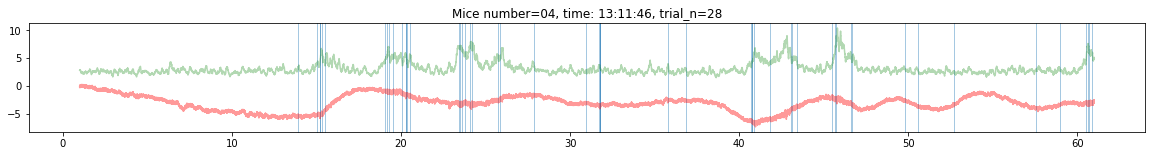

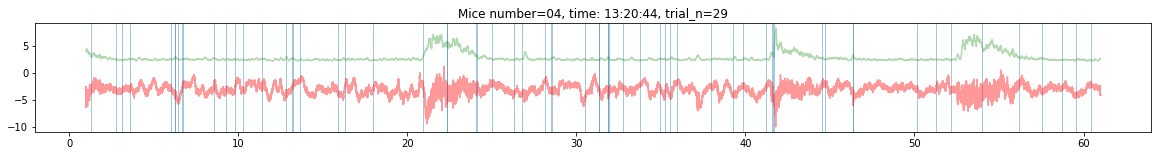

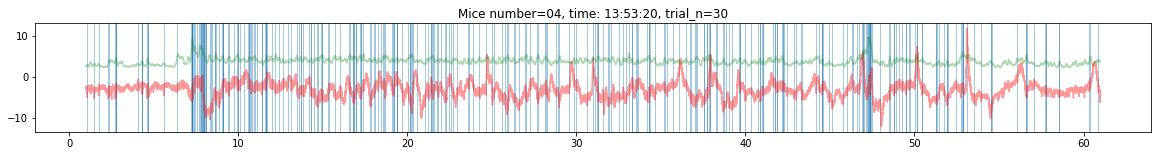

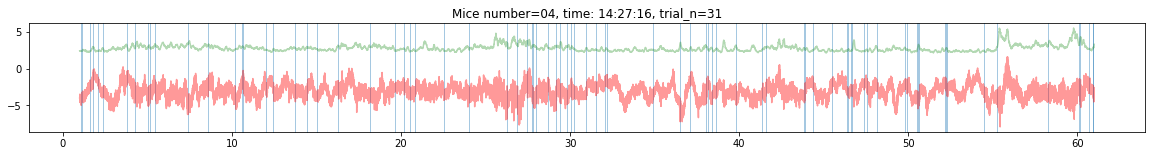

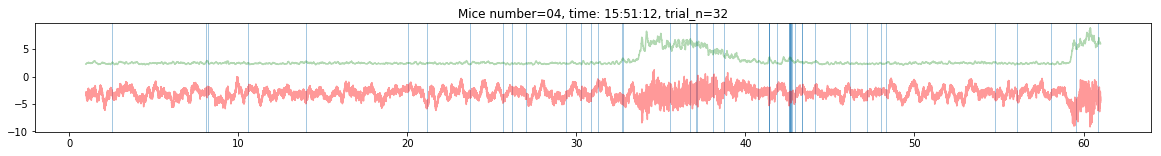

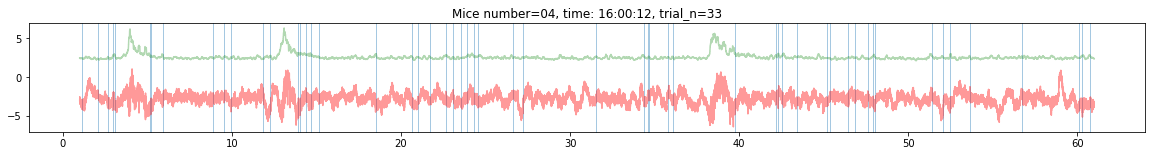

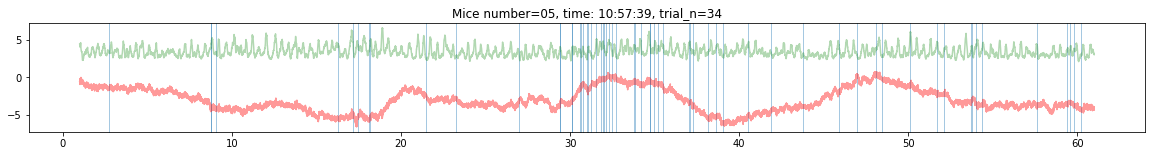

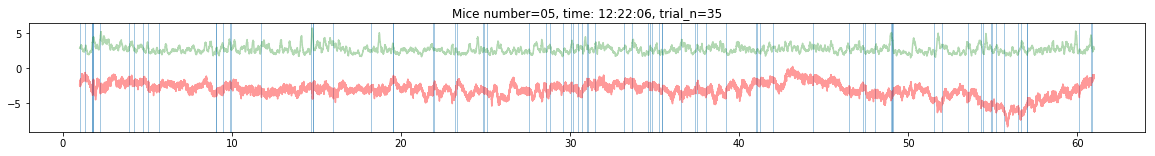

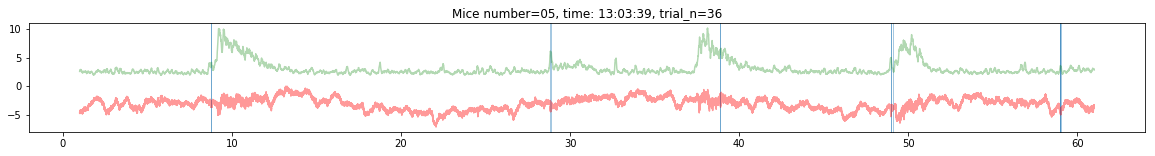

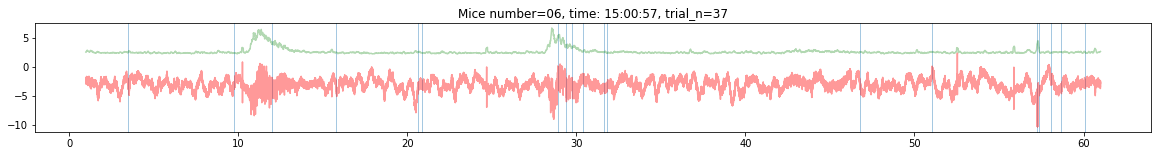

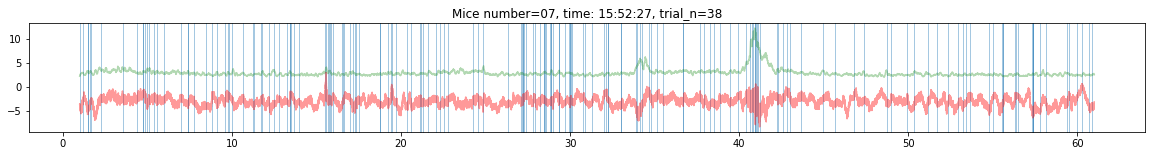

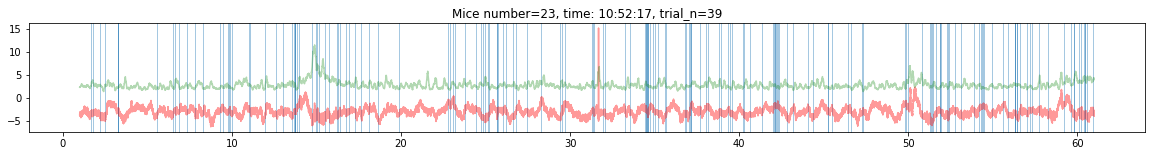

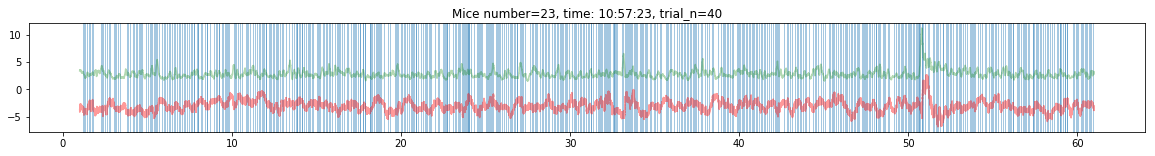

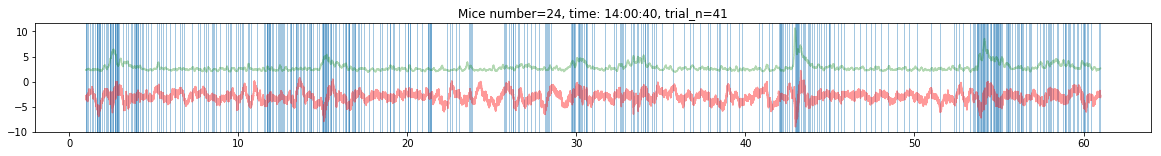

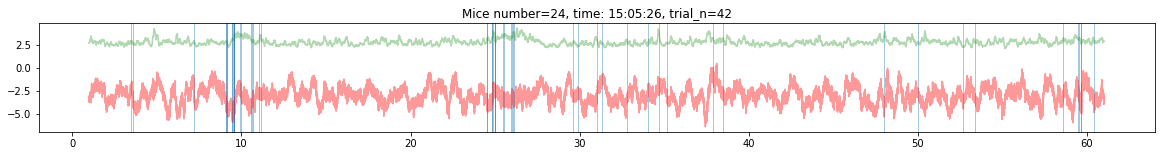

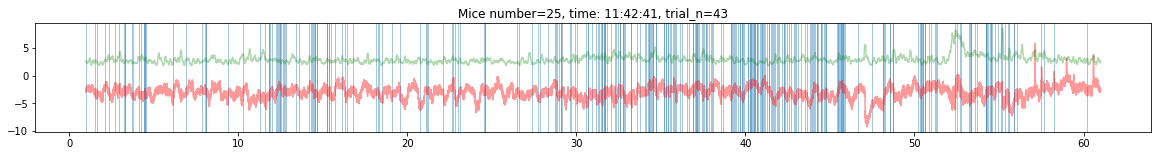

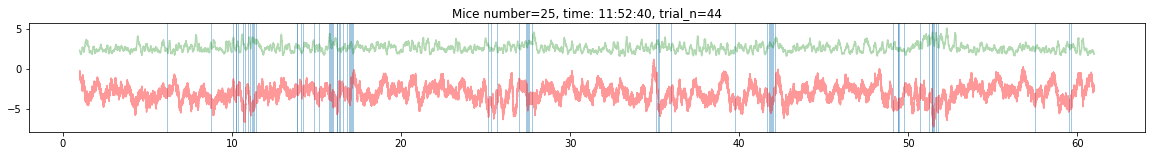

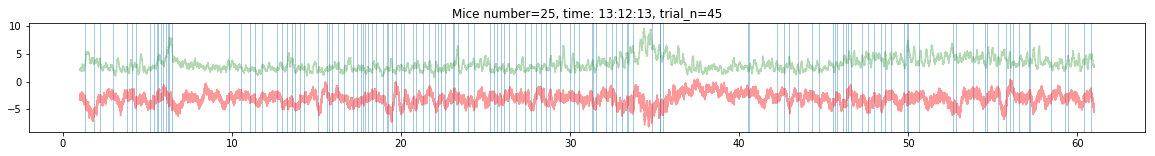

In [830]:
t_plt_begin = 4000; t_plt_period = 240000;
for trial_n in range(46):
    # timing
    t_plt_end=t_plt_begin+t_plt_period
    time_range = list(range(t_plt_begin,t_plt_end))
    time_range=np.multiply(1/4000,time_range)
    
    # plot spikes
    spks_times_plt = [t for t in spike_times[trial_n] \
                      if (t  > t_plt_begin and t < t_plt_end)]
    spks_times_plt = np.multiply(1/4000,spks_times_plt)
    spk_tics_plt=[1]*len(spks_times_plt)
    plt.plot(spks_times_plt, spk_tics_plt, linestyle='', \
             marker='|', alpha=.4, markersize=200)

    # plot EMG
    emg_z = sp.stats.zscore(emgs[trial_n])
    plt.plot(time_range,emg_z[t_plt_begin:t_plt_end]-3,'r-',alpha=.4)
    
    # plot muscle activity
    musc_z = sp.stats.zscore(musc[trial_n])
    plt.plot(time_range,musc_z[t_plt_begin:t_plt_end]+3,'g',alpha=.3)
    
    # plot features
    tr_name = file_names_3ch[trial_n]
    mice_n = tr_name[0:2] 
    rec_time = tr_name[3:5] + ':' + tr_name[5:7] + ':' + tr_name[7:9]
    plt.title('Mice number=' + mice_n + ', time: ' + rec_time + ', trial_n=' + str(trial_n))
    fig = plt.gcf()
    fig.set_size_inches(20,2)
    plt.show() 
    # [0.33, 0.51, 6.24 , 0.53, 0.97, 1.72, 0.48 , 0.93, 5.17])

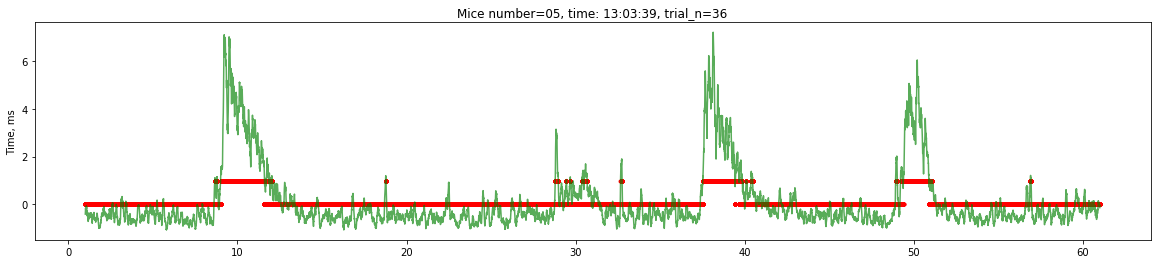

In [888]:
t_plt_begin = 4000; t_plt_period = 240000;


for trial_n in [36]:
    # timing
    t_plt_end=t_plt_begin+t_plt_period
    time_range = list(range(t_plt_begin,t_plt_end))
    time_range=np.multiply(1/4000,time_range)
    
    msc_high = [msc>1 for msc in musc_z]
    plt.plot(time_range,msc_high[t_plt_begin:t_plt_end],'ro',alpha=.9, markersize=3)
    
    # plot muscle activity
    musc_z = sp.stats.zscore(musc[trial_n])
    plt.plot(time_range,musc_z[t_plt_begin:t_plt_end],'g',alpha=.65)

           
    # plot features
    tr_name = file_names_3ch[trial_n]
    mice_n = tr_name[0:2] 
    rec_time = tr_name[3:5] + ':' + tr_name[5:7] + ':' + tr_name[7:9]
    plt.title('Mice number=' + mice_n + ', time: ' + rec_time + ', trial_n=' + str(trial_n))
    fig = plt.gcf()
    fig.set_size_inches(20,4)
    plt.ylabel('Time, ms')
    plt.show() 
    # [0.33, 0.51,

#### Create helping spike arrays

In [800]:
# create binary spike timing array
spikes_bin = [0]*len(trials)
for trial_n in range(len(trials)):
    spike_times[trial_n] = [ int(t) for t in spike_times[trial_n] ] 
    spikes_bin[trial_n] = np.zeros(len(emgs[trial_n]))
    spikes_bin[trial_n][spike_times[trial_n]]=1

In [801]:
# Interspike interval
isi=[0]*len(trials)
for trial_n in range(len(trials)):
    isi[trial_n] = [int(spike_times[trial_n][n+1] - spike_times[trial_n][n]) \
                    for n in range( len(spike_times[trial_n]) -1 ) ]    

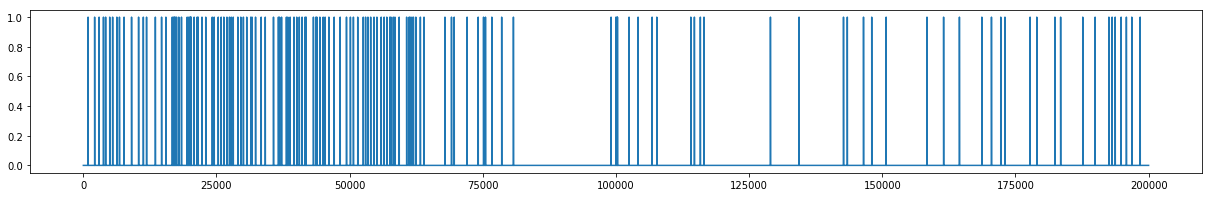

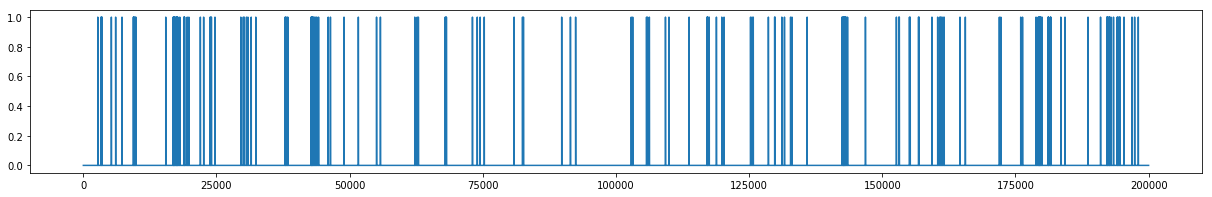

0.8394202080578604
0.6674410828578557


In [774]:
plt.plot(spikes_bin[0][200000:400000])
# plot properties and show
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

plt.plot(spikes_bin[1][200000:400000])
# plot properties and show
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

t0 = 200000; t1= 400000;
isi0sec = [isi[0][k]/4000 for k in range(len(spike_times[0])) \
        if (spike_times[0][k]>t0 and spike_times[0][k]<t1)]
isi1sec = [isi[1][k]/4000 for k in range(len(spike_times[1])) \
        if (spike_times[1][k]>t0 and spike_times[1][k]<t1)]


def fano(x):
    # x is the vector with ISI
    varX = np.var(x); meanX = np.mean(x);
    return varX/meanX

print(fano(isi0sec))
print(fano(isi1sec))

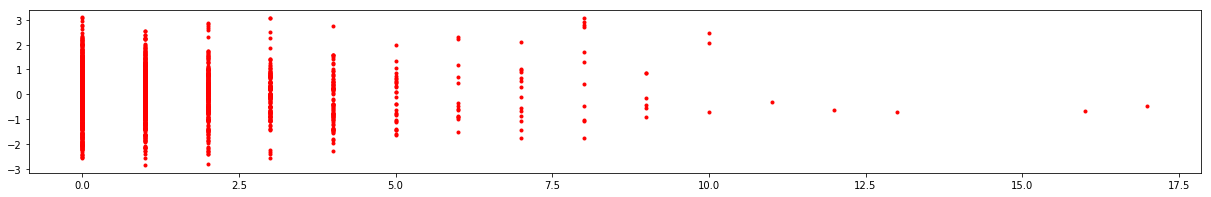

In [816]:
# create spike rate array
t_window = 6000;
trial_n = 34
spikes_freq = []; musc_level = []; emg_level = [];
for t in range(0,len(spikes_bin[trial_n])-t_window,2000):
    spikes_freq.append(sum(spikes_bin[trial_n][t:t+t_window]))
    musc_level.append(np.mean(musc[trial_n][t:t+t_window]))
    emg_level.append(np.mean(emgs[trial_n][t:t+t_window]))
plt.plot(spikes_freq,emg_level,'r.')
# plt.plot(sp.stats.zscore(musc_level),'r')
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

In [802]:
fanos=np.empty(len(emgs))
for tn in range(len(emgs)):
    isi_n = [i/4000 for i in isi[tn]]
    fanos[tn] = fano(isi_n)
fanos
    

array([ 6.08501636,  1.43893085,  0.98415043,  2.86226143,  1.33390015,
        1.39183044,  1.27725073,  3.57905853,  3.58337529,  0.13459072,
        2.51826415,  5.14486872, 12.32172253,  0.32940463,  2.9981028 ,
        1.89453427, 17.43614484, 15.13649379,  4.06139062,  0.40182056,
        0.27609714,  0.11572358,  0.13521045,  3.0307684 , 20.35652947,
        0.50856459,  1.50569867,  3.54928635,  6.2409427 ,  0.95125453,
        0.52866295,  0.968451  ,  1.30115447,  0.99624217,  3.13043304,
        1.72275352,  9.37018744,  4.36171301,  0.38474459,  0.4097568 ,
        0.02758008,  0.4844643 ,  2.46238063,  0.93047545,  5.17174564,
        0.40632543])

In [803]:
freqs=np.empty(len(emgs))
for tn in range(len(emgs)):
    freq = len(spike_times[tn])*4000/len(emgs[tn])
    freqs[tn] = freq
freqs

array([ 3.96911933,  1.03896792,  3.59142959,  2.30601433,  1.46054058,
        2.89846417,  1.79782752,  0.71097182,  0.33381816,  6.56167116,
        0.77758568,  0.56843726,  0.06356235,  3.69486492,  0.61972426,
        1.43201469,  0.13577972,  0.20562002,  0.4957713 ,  2.32528774,
        3.34824674,  6.95297842,  6.06718515,  0.72940882,  0.3965076 ,
        2.84066227,  1.62581799,  0.72746149,  1.01981847,  0.98986096,
        3.22091051,  1.92446768,  0.79405672,  0.94042247,  0.7375277 ,
        1.14148   ,  0.19036453,  0.36023055,  2.91841295,  5.48841792,
       11.30119987,  5.66914147,  2.68775148,  4.93696442,  1.96258363,
        2.37641592])

In [ ]:
tr_n=34
for

In [810]:
entropies = [sp.stats.entropy(isi[n]) for n in range(len(emgs)) ]
entropies

[4.4972691084526595,
 4.720600038664037,
 4.949710323745297,
 4.238900392454257,
 4.336688252604132,
 5.050122793559882,
 4.916043832680913,
 2.9284063014786756,
 3.334701380708356,
 7.097700818045984,
 3.9289808814053693,
 2.9647555565734067,
 2.83873905926204,
 6.683746412340636,
 3.7331482651371752,
 4.185385834226848,
 3.9853709610080594,
 3.3607869730278956,
 3.913718772023201,
 5.795197311735073,
 6.306630928321521,
 6.879339815282947,
 6.605823233023651,
 4.851112397393646,
 2.5017158225290115,
 8.11900785438665,
 4.8695428135928305,
 6.738860905483,
 6.764790594060556,
 4.916381229615199,
 6.805396145588581,
 6.427938338419052,
 5.727885015904869,
 6.428082360071641,
 5.906849542382089,
 5.669323563713611,
 3.5511788066119894,
 4.846906885392931,
 5.387150187553024,
 6.101707114291352,
 7.7472548115831605,
 7.6406066556630465,
 5.273058349602974,
 7.316406889502864,
 6.28320312306812,
 5.857310730177746]

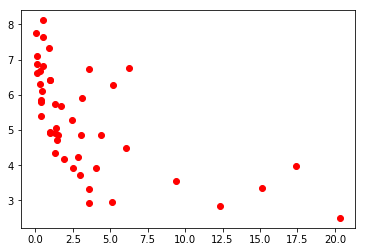

In [812]:
plt.plot(fanos,entropies,'ro')
plt.show()

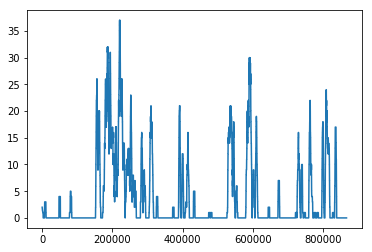

In [613]:
# create spike rate array
t_window = 4000;
trial_n = 0
spikes_freq = [0]*len(spikes_bin[trial_n]-1)
for t in range(len(spikes_bin[trial_n])):
    early = (t-t_window/2) < 0
    late = (t+t_window/2) > len(spikes_bin[trial_n])
    t_start = (t-t_window/2) * (not early)
    t_start = int(t_start)
    t_end = ( (t+t_window/2) * (not late) ) + late * len(spikes_bin[trial_n])
    t_end = int(t_end)
    spikes_freq[t] = sum(spikes_bin[trial_n][t_start:t_end])*4000/(t_end-t_start)
plt.plot(spikes_freq)
plt.show()

### Compute Fano factor (measure burstiness)

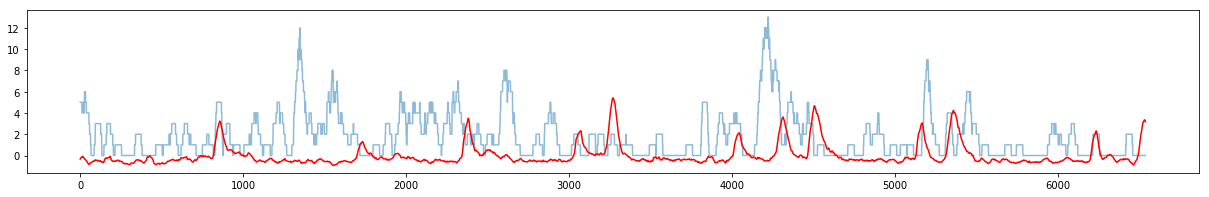

In [675]:
# create spike rate array
t_window = 4000;
trial_n = 6
spikes_freq = []; musc_level = []
for t in range(0,len(spikes_bin[trial_n])+4001,100):
    spikes_freq.append(sum(spikes_bin[trial_n][t:t+4000]))
    musc_level.append(np.mean(musc[trial_n][t:t+4000]))
plt.plot(spikes_freq,alpha=.5)
plt.plot(sp.stats.zscore(musc_level),'r')
fig = plt.gcf()
fig.set_size_inches(21,3)
plt.show()

In [792]:
# create spike rate array
t_window = 2000;
# trial_n = 7
spikes_freq = [0]*10; musc_level = [0]*10
for trial_n in range(10):
    spikes_freq[trial_n]=[]; musc_level[trial_n] =  []
    for t in range(0,len(spikes_bin[trial_n])+t_window,400):
        spikes_freq[trial_n].append(sum(spikes_bin[trial_n][t:t+t_window]))
        musc_level[trial_n].append(np.mean(musc[trial_n][t:t+t_window]))
#     plt.plot(spikes_freq[trial_n][:800],alpha=.5)
#     plt.plot(sp.stats.zscore(musc_level[trial_n][:800]),'r')
#     fig = plt.gcf()
#     fig.set_size_inches(21,3)
#     plt.show()

C:\Users\leopt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\leopt\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

In [ ]:
# create spike rate array
t_window = 2000;
# trial_n = 7
spikes_freq = [0]*10; musc_level = [0]*10
for trial_n in [7]:
    spikes_freq[trial_n]=[]; musc_level[trial_n] =  []
    for t in range(0,len(spikes_bin[trial_n])+t_window,400):
        spikes_freq[trial_n].append(sum(spikes_bin[trial_n][t:t+t_window]))
        musc_level[trial_n].append(np.mean(musc[trial_n][t:t+t_window]))
    plt.plot(spikes_freq[trial_n][:800],alpha=.5)
    plt.plot(sp.stats.zscore(musc_level[trial_n][:800]),'r')
    fig = plt.gcf()
    fig.set_size_inches(21,3)
    plt.show()

In [889]:
# create spike rate array
t_window = 8000;
# trial_n = 7
spikes_freq = [0]*len(emgs); musc_level = [0]*len(emgs); cors_musc = [0]*len(emgs)
for trial_n in range(len(emgs)):
    spikes_freq[trial_n]=[]; musc_level[trial_n] =  []
    for t in range(0,len(spikes_bin[trial_n])-t_window,4065):
        spks = [sp for sp in spike_times if (sp)]
        spikes_freq[trial_n].append(sum(spikes_bin[trial_n][t:t+t_window]))
        musc_level[trial_n].append(np.mean(musc[trial_n][t:t+t_window]))
    cors_musc[trial_n] = np.corrcoef(spikes_freq[trial_n], musc_level[trial_n])[1][0]
cors_musc

[0.6568903149724352,
 0.17975876394066004,
 -0.015540816622756127,
 -0.0688377958868738,
 0.18302522708748492,
 0.7064638572614419,
 0.0196688894456056,
 0.26178535509300455,
 0.010176639305479487,
 0.038358418571442524,
 0.44794552497906254,
 0.13932936280116942,
 -0.04408293602175246,
 -0.2877030786571925,
 0.6337554913832665,
 0.5152514453246845,
 0.31809838754582537,
 0.2595906357117916,
 0.5379523843508158,
 0.41155651453974496,
 0.6845836336859823,
 0.14251893633872745,
 -0.1716735488146504,
 0.19463107788234707,
 0.7283763076451628,
 0.5330502374977942,
 0.7205394695747912,
 0.49785248288132755,
 0.4773742625456192,
 -0.12780432458021593,
 0.876980262761202,
 -0.49800928620440726,
 0.03925284643393701,
 0.06627530672684434,
 -0.00944980252256175,
 0.102880933141708,
 0.17803849976297986,
 0.14815195266672568,
 0.2492013201068105,
 0.36112120011453047,
 -0.31785495027616256,
 0.5329788107611629,
 0.2976980643247873,
 0.1667922833666507,
 0.6215226345478728,
 0.0804069183941205]

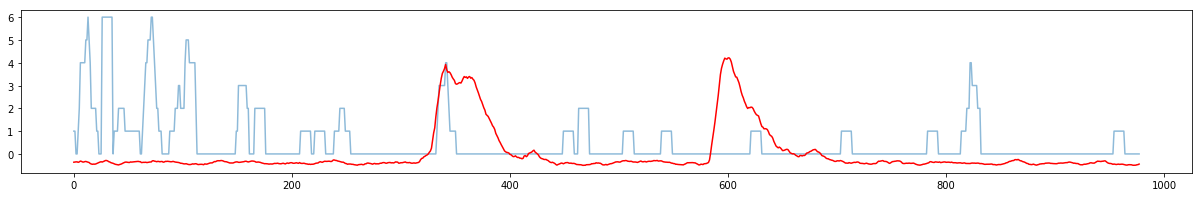

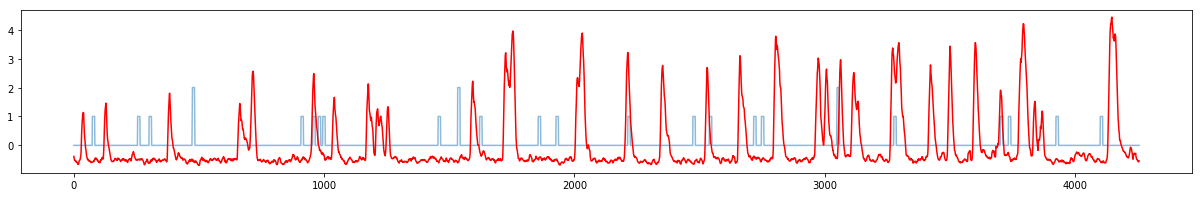

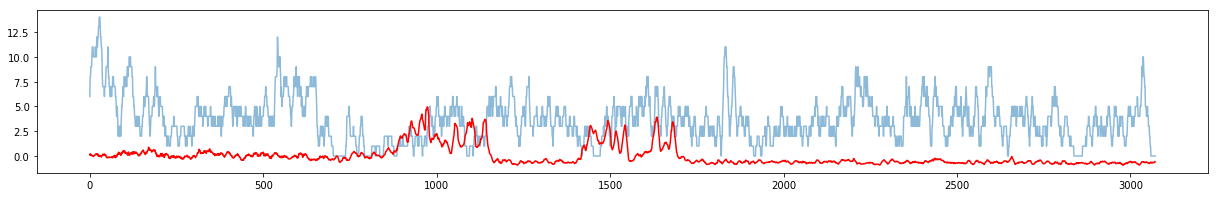

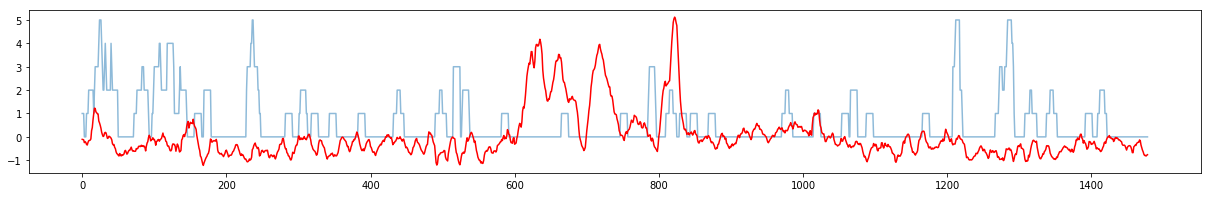

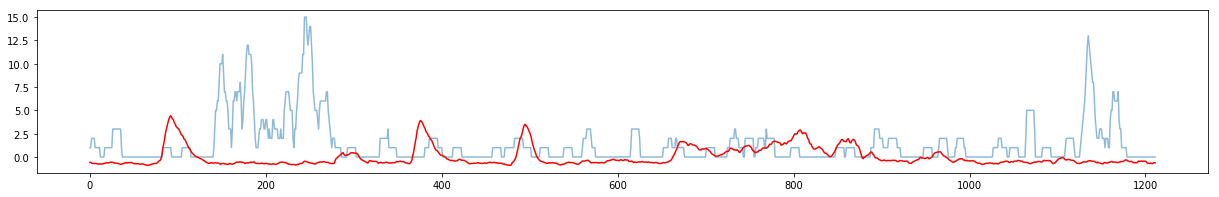

C:\Users\leopt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\leopt\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


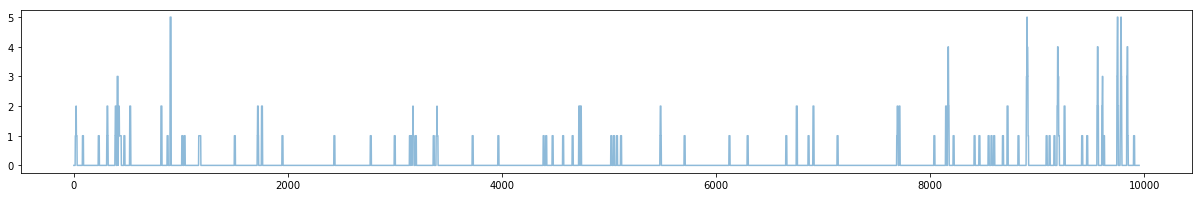

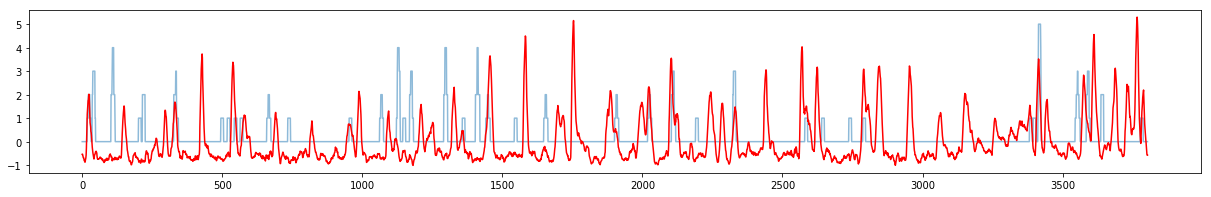

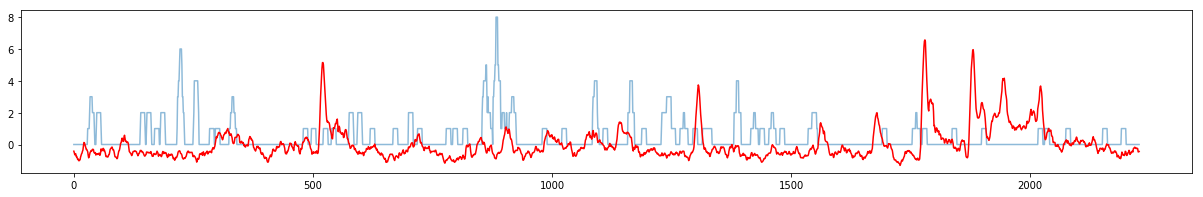

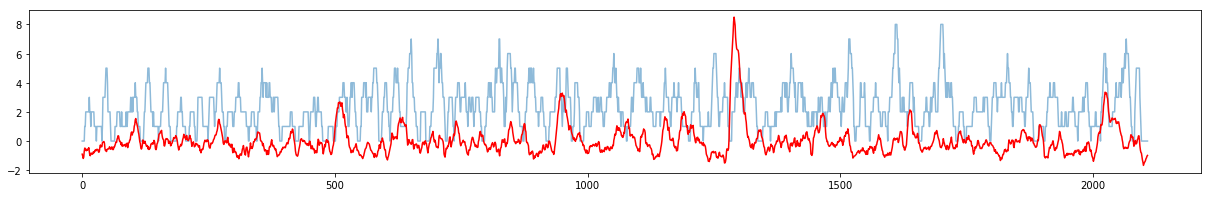

In [684]:
# create spike rate array
t_window = 2000;
# trial_n = 7
spikes_freq = [0]*19; musc_level = [0]*19
for trial_n in range(10,19):
    spikes_freq[trial_n]=[]; musc_level[trial_n] =  []
    for t in range(0,len(spikes_bin[trial_n])+4001,400):
        spikes_freq[trial_n].append(sum(spikes_bin[trial_n][t:t+4000]))
        musc_level[trial_n].append(np.mean(musc[trial_n][t:t+4000]))
    plt.plot(spikes_freq[trial_n],alpha=.5)
    plt.plot(sp.stats.zscore(musc_level[trial_n]),'r')
    fig = plt.gcf()
    fig.set_size_inches(21,3)
    plt.show()

In [610]:
k=np.array([123,2,31,234,1234,653])
ks=np.array([l>100 for l in k])
k[ks]

array([ 123,  234, 1234,  653])

In [848]:
rand_cut_n = 2000; time_pre = 8000; time_post = 4000;
emg_cuts_pre = np.empty((len(trials),rand_cut_n),dtype=list)
spike_cuts_pre = np.empty((len(trials),rand_cut_n),dtype=list)
musc_cuts_pre = np.empty((len(trials),rand_cut_n),dtype=list)
emg_cuts_post = np.empty((len(trials),rand_cut_n),dtype=list)
spike_cuts_post = np.empty((len(trials),rand_cut_n),dtype=list)
musc_cuts_post = np.empty((len(trials),rand_cut_n),dtype=list)
time_starts = np.empty((len(trials),rand_cut_n), dtype=int)

for trial_n in [34,44]:
    for ind in range(rand_cut_n):
        t_start = random.randint(time_pre,len(emgs[trial_n])-time_post)
        time_starts[trial_n][ind] = t_start # store the start times
        emg_cuts_pre[trial_n][ind] = emgs[trial_n][t_start-time_pre : t_start]
        spike_cuts_pre[trial_n][ind] = spikes_bin[trial_n][t_start-time_pre:t_start] # CHANGE
        musc_cuts_pre[trial_n][ind] = musc[trial_n][t_start-time_pre : t_start]
        emg_cuts_post[trial_n][ind] = emgs[trial_n][t_start : t_start+time_post]
        spike_cuts_post[trial_n][ind] = spikes_bin[trial_n][t_start : t_start+time_post]
        musc_cuts_post[trial_n][ind] = musc[trial_n][t_start : t_start+time_post]  
        
trial_n

44

In [845]:
len(emgs[34])/4000

1107.755

In [849]:
spike_freq_pre = np.empty((len(trials),rand_cut_n),dtype=list)

musc_level_pre = np.empty((len(trials),rand_cut_n),dtype=list)

emg_change_abs_post = np.empty((len(trials),rand_cut_n),dtype=list)
emg_change_post = np.empty((len(trials),rand_cut_n),dtype=list)
emg_level_pre = np.empty((len(trials),rand_cut_n),dtype=list)

for trial_n in [34,44]:
    for ind in range(rand_cut_n):
        spike_freq_pre[trial_n][ind] =  sum(spike_cuts_pre[trial_n][ind])*4000/time_pre
        
        musc_level_pre[trial_n][ind] = np.mean(musc_cuts_pre[trial_n][ind])
        
        
        emg_change_abs_post[trial_n][ind] = \
                abs(np.mean(emg_cuts_post[trial_n][ind]) \
                    - np.mean(emg_cuts_pre[trial_n][ind]))
        emg_change_post[trial_n][ind] = \
                np.mean(emg_cuts_post[trial_n][ind]) \
                    - np.mean(emg_cuts_pre[trial_n][ind])
        emg_level_pre[trial_n][ind] = np.mean(emg_cuts_pre[trial_n][ind])
    


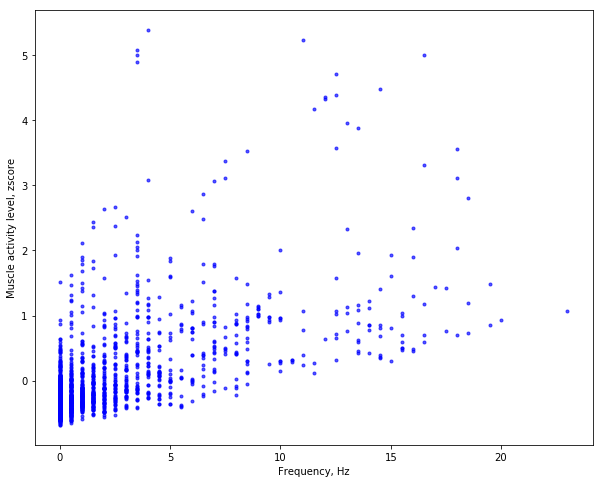

In [868]:
plt.plot(spike_freq_pre[44],musc_level_pre[44], color= 'b', linestyle='', \
         marker='.', markersize=6, alpha=0.66)
# plt.plot(spike_freq_pre[6],musc_level_pre[6], color= 'r', linestyle='', \
#          marker='.', markersize=3, alpha=0.6)
# plt.plot(spike_freq_pre[9],emg_level_pre[9], 'bo')
plt.xlabel('Frequency, Hz')
plt.ylabel('Muscle activity level, zscore')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [874]:
### from scipy.stats import linregress
l=linregress(list(spike_freq_pre[44]),list(musc_level_pre[44]))
# musc_level_pre[44]
l[3]*1000

1.842082677957217e-201

In [870]:
from scipy.stats import linregress
l=linregress(list(spike_freq_pre[34]),list(emg_level_pre[34]))
# musc_level_pre[44]
l

LinregressResult(slope=-0.02367370984851975, intercept=0.02052972726560667, rvalue=-0.0249094124302876, pvalue=0.26551130137295764, stderr=0.021255450693798125)

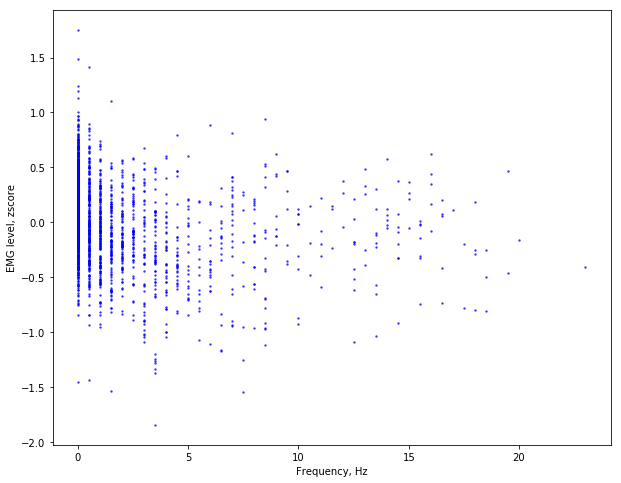

In [869]:
plt.plot(spike_freq_pre[44],emg_level_pre[44], color= 'b', linestyle='', \
         marker='.', markersize=3, alpha=0.6)
# plt.plot(spike_freq_pre[6],musc_level_pre[6], color= 'r', linestyle='', \
#          marker='.', markersize=3, alpha=0.6)
# plt.plot(spike_freq_pre[9],emg_level_pre[9], 'bo')
plt.xlabel('Frequency, Hz')
plt.ylabel('EMG level, zscore')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

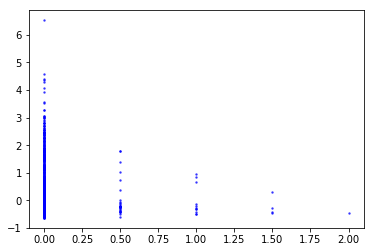

In [669]:
plt.plot(spike_freq_pre[7],musc_level_pre[7], color= 'b', linestyle='', \
         marker='.', markersize=3, alpha=0.6)
plt.show()

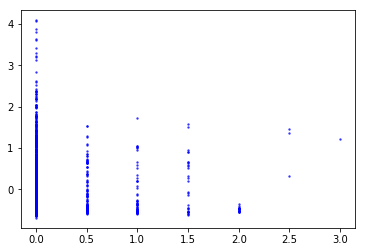

In [667]:
plt.plot(spike_freq_pre[16],musc_level_pre[16], color= 'b', linestyle='', \
         marker='.', markersize=3, alpha=0.6)
plt.show()

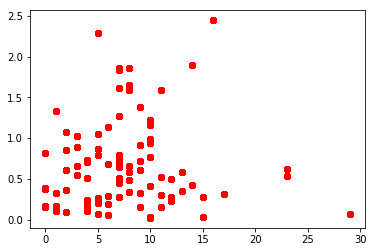

In [287]:

for trial_n in range(len(trials)):
    plt.plot(spike_freq_pre[trial_plot],emg_change_abs_post[trial_plot], 'ro')
plt.show()

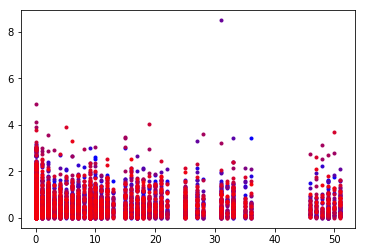

In [293]:
color_incr = 1/(len(trials)+1)
for n_plt in range(len(trials)):
    color_plt = (0+color_incr*n_plt,0,1-color_incr*n_plt)
    plt.plot(spike_count_pre[0],emg_change_abs_post[n_plt], color=color_plt, marker='.', linestyle='')

plt.show()

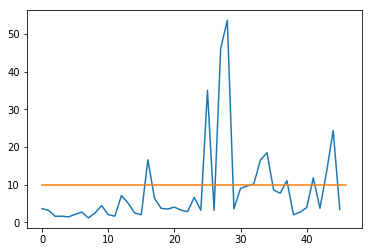

array([ 1.1486625 ,  1.4264125 ,  1.56390833,  1.6045    ,  1.61260833,
        2.00184167,  2.010225  ,  2.01478333,  2.0930625 ,  2.44644167,
        2.447325  ,  2.68140417,  2.70697083,  2.80195833,  3.14414583,
        3.1778875 ,  3.19455833,  3.23122917,  3.38745417,  3.497775  ,
        3.5526875 ,  3.6112125 ,  3.69794167,  3.70197917,  3.89486667,
        4.01205   ,  4.43484583,  5.101675  ,  6.32234167,  6.62637083,
        7.0796625 ,  7.70451667,  8.52694167,  8.98814167,  9.6043875 ,
       10.15880417, 11.05773333, 11.78602917, 13.30102083, 16.48195417,
       16.57095833, 18.46258333, 24.35565   , 35.00944167, 46.07345833,
       53.62065417])

In [316]:
# SOMETHING STRANGE
spike_ns = []
trial_lens = []
spike_freqs = []
for trial_n in range(len(trials)):
    n_spikes=sum(spikes[trial_n]);
    spike_ns.append(n_spikes)
    tr_len = len(emgs[trial_n])
    trial_lens.append(tr_len/(60*4000))
    spike_freqs.append(4000*n_spikes/tr_len)
    
plt.plot(trial_lens); 
plt.plot([0, 20, 46],[10, 10, 10])
plt.show()
np.sort(trial_lens)

In [891]:
# trial_props = [ [freqs[n], entropies[n], fanos[n]] for n in range(len(emgs))]
trial_props = [ [ freqs[n], cors_musc[n] ] for n in range(len(emgs))]
kmeans = KMeans(n_clusters=2, random_state=0).fit(trial_props)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0])

In [892]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(trial_props)
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0], dtype=int64)

C:\Users\leopt\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\Users\leopt\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


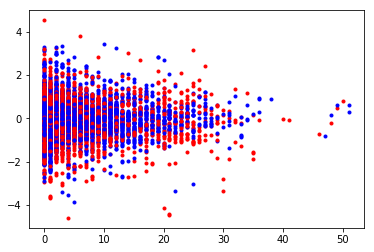

In [291]:
# select the ones without change
## OPTIMIZE LATER
changes =  np.empty((len(trials),rand_cut_n),dtype=list);
nochanges =  np.empty((len(trials),rand_cut_n),dtype=list);

for trial_n in range(len(trials)):
    k=type(emg_change_abs_post[trial_n])
    nochanges[trial_n] = emg_change_abs_post[trial_n]<0.5; 
    changes[trial_n] = emg_change_abs_post[trial_n]>0.5;
    ch_inds = list(changes[trial_n])
    noch_inds = list(nochanges[trial_n])
    plt.plot(spike_count_pre[trial_n][ch_inds], emg_level_pre[trial_n][ch_inds], \
             color=(1,0,0),marker='.',linestyle='')
    plt.plot(spike_count_pre[trial_n][noch_inds], emg_level_pre[trial_n][noch_inds], \
             color=(0,0,1),marker='.', linestyle='')
plt.show()

In [260]:
k=np.array([4,55,2,75,24,2])
c= k>11
c

array([False,  True, False,  True,  True, False])

In [257]:
# plot in 2 colors changed (red) and not changed emg (blue)
plt.plot(spike_count_pre[0][changes], level_pre[0][changes], 'ro')
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
# create an array with interspike intervals preceding some start point
starts = cuts
isi_cuts
for time_point in range(starts):
    tp_pre = time_point - time_pre;
    tp_post = time_point + time_post;
    spike_times[]
    results = [t.age for t in mylist if t.person_id == 10]

In [ ]:
# Dimentionality reduction

Organize the data
1. convert to zscores
2. plot

Take parameters from spike activity
1. firing rate
2. interspike interval

Take parameters  from EMG

Prepare data for machine learning
1. segment
2. 

len(file_names_3ch

In [133]:
len(spike_times[5])

1746

In [156]:
times = [3, 5, 9]
times[1]=11
np.multiply([1, 2],[5, 2])

array([5, 4])

In [424]:
f=[0,1,1,0,0,0,0,0,1,0,1]
sum(f)

4

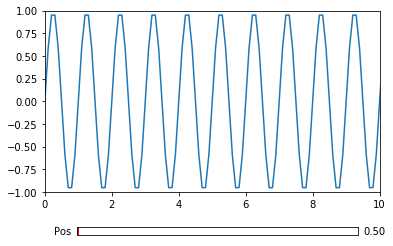

In [692]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

t = np.arange(0.0, 100.0, 0.1)
s = np.sin(2*np.pi*t)
l, = plt.plot(t,s)
plt.axis([0, 10, -1, 1])

axcolor = 'lightgoldenrodyellow'
axpos = plt.axes([0.2, 0.1, 0.65, 0.03])

spos = Slider(axpos, 'Pos', 0.1, 90.0)

def update(val):
    pos = spos.val
    ax.axis([pos,pos+10,-1,1])
    fig.canvas.draw_idle()

spos.on_changed(update)

plt.show()

In [632]:
k= [ int(t) for t in spike_times[0] ] 
#results = [t.age for t in mylist if t.person_id == 10]